In [2]:
import numpy as np
import pandas as pd


import plotly.graph_objects as go
import plotly.figure_factory as ff


# библиотеки для визуализации
import plotly
#import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from scipy.stats import shapiro, normaltest # для тестов на нормальность

In [3]:
data = pd.read_csv('acquiredDataset.csv')
print(data.shape)
data.head()

(3735, 11)


,attention,meditation,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,classification
0,26,34,960462,277180,26575,27356,26575,13056,9126,2683,0
1,29,54,39145,28225,20172,39551,20172,9933,5237,4750,0
2,40,48,75410,43144,8601,13564,8601,11663,2515,3251,0
3,66,47,16057,41211,2534,34254,2534,27663,11396,2825,0
4,81,67,10304,47239,33158,47349,33158,16328,5298,5471,0


In [4]:
# посмотрим на структуру столбцов

# создаём пустой список
unique_list = []
# пробегаемся по именам столбцов в таблице
for col in data.columns:
    # создаём кортеж (имя столбца, число уникальных значений, тип столбца, уникальные значения)
    item = (col, data[col].nunique(), data[col].dtypes, data[col].min(), data[col].max(), data[col].isnull().sum(), data[data[col] == 0].shape[0], data[col].mean(), data[col].median()) 
    # добавляем кортеж в список
    unique_list.append(item) 
# создаём вспомогательную таблицу и сортируем её по количеству уникальных значений в столбце
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type', 'Min', 'Max', 'NaN', 'Zero', 'Mean', 'Median']
).sort_values(by='Num_Unique',  ignore_index=True)
unique_counts

,Column_Name,Num_Unique,Type,Min,Max,NaN,Zero,Mean,Median
0,classification,2,int64,0,1,0,2135,0.428380,0.0
1,attention,60,int64,1,100,0,0,48.214726,48.0
2,meditation,60,int64,1,100,0,0,56.577510,56.0
3,lowGamma,3259,int64,6,289281,0,0,8117.130388,4440.0
4,highBeta,3494,int64,3,443589,0,0,23276.979384,9739.0
5,highAlpha,3561,int64,9,785947,0,0,30580.759036,14928.0
6,lowBeta,3573,int64,2,595549,0,0,25640.069076,13841.0
7,lowAlpha,3601,int64,32,699008,0,0,33413.343775,16481.0
8,highGamma,3651,int64,47,2328370,0,0,208725.809906,57198.0
9,theta,3680,int64,138,3194358,0,0,136242.001874,57972.0


In [5]:
data.duplicated().sum() # проверяем количество дубликатов в таблице

0

1) Все столбцы содержат численные значения: столбец 'classification' является категориальным и его мы кодировать не будем, поскольку он содержит категории, которые мы собираемся предсказывать (0 - сонное состояниеб 1 - состояние бодрствования), все остальные признаки являются непрерывными, их мы тоже не будем кодировать.

2) Пропущенных значений нет (также нет нулей, которыми исследователи могли бы заполнить пропущенные данные), поэтому нет необходимости избавляться от пропусков 

3) Классы (столбец 'classification') довольно сбалансированы (0.43% единиц и 0.57% нулей, разница не превышает 20%), поэтому дисбаланс выборки можно не учитывать

In [6]:
data.isnull().sum()

data['attention'].isnull().sum()

0

In [7]:
col_list = list(data.columns) # создаём список признаков
col_list.pop(-1) # убираем признак classification из списка
col_list

['attention',
 'meditation',
 'delta',
 'theta',
 'lowAlpha',
 'highAlpha',
 'lowBeta',
 'highBeta',
 'lowGamma',
 'highGamma']

In [8]:
# посмотрим на распределения признаков

# создаём по таблице график, в котором каждому столбцу соответствует своя гистограмма (подграфик)
n_row = 5 # устанавливаем количество подграфиков в графике по вертикали
n_col = 2 # устанавливаем количество подграфиков в графике по горизонтали

fig = make_subplots(rows=n_row, cols=n_col, subplot_titles=col_list) 

ind = 0
for row in range(1, n_row+1):
    for col in range(1, n_col+1):
        fig.append_trace(go.Histogram(x=data[col_list[ind]]), row, col)
        fig.update_layout(height=800, width=1300)  # указываем высоту и ширину графика
        fig.update_layout(showlegend=False)  # скрываем легенду
        ind += 1

fig.show()

In [9]:
data.columns

Index(['attention', 'meditation', 'delta', 'theta', 'lowAlpha', 'highAlpha',
       'lowBeta', 'highBeta', 'lowGamma', 'highGamma', 'classification'],
      dtype='object')

In [10]:
data['attention'].mean()

48.214725568942434

In [11]:
# посмотрим, как соотносятся средние значения каждого признака для каждой категории столбца classification (0 и 1)

mean_table = data.groupby('classification')[col_list].mean().T # создаём сводную таблицу со средними значениями
#mean_table = data.groupby('classification')[data_col].mean().round().T # создаём сводную таблицу со средними значениями
#mean_table = mean_table.astype(int)

# строим по этой таблице график
fig = px.bar(
    mean_table, 
    x=mean_table.columns, 
    y=mean_table.index, 
    title='Средние значения для каждой из категорий столбца classification', 
    barmode='group'
    )

fig.show()

Примечание: масштаб для признаков meditation и attention (их средние значения примерно равны 50) можно регулировать, поскольку используется библиотека plotly.

Если смотреть в целом, то можно увидеть преобладание категории 0 (кроме столбца attention) между средними значениями по каждому признаку

In [12]:
#fig = px.bar(
#    mean_table, 
#    x=mean_table.columns, 
#    y=mean_table.index, 
#    title='Средние значения для каждой из категорий столбца classification'
#    )
#fig.show()

In [13]:
# построим коробчатые диаграммы

# создаём по таблице график, в котором каждому столбцы соответствует своя коробчатая диаграмма (подграфик)
n_row = 10 # количество подграфиков по вертикали
n_col = 1 # количество подграфиков по вертикали

fig = make_subplots(rows=n_row, cols=n_col, subplot_titles=col_list) # создаёт фигуру из нескольких подграфиков
# (последний параметр настраивает название подграфика)

ind = 0 # номер элемента из списка со столбцами датафрейма (col_list)
# проходимся по каждому элементу каждой "строки" графика
for row in range(1, n_row+1): # проходимся по каждому элементу каждой "строки" графика
    for col in range(1, n_col+1):
        fig.append_trace(go.Box(x=data[col_list[ind]], name=''), row, col) # настраиваем каждый подграфик
        fig.update_layout(height=1300, width=1300)  # указываем высоту и ширину графика
        fig.update_layout(showlegend=False)  # скрываем легенду
        ind += 1

fig.show()

In [14]:

# функция, которая возвращает датафрейм без строк, в которых значение в конкретном столбце 
# выходит за границы (Q1 - 1,5IQR) или (Q3 + 1,5IQR)
def outliers_iqr(df, feature):
    quartile_1, quartile_3 = df[feature].quantile(0.25), df[feature].quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return outliers, df

In [15]:
# функция, которую мы применять не будем, поскольку признак meditation мы всё равно в обучении не используем

# (мы попробовали с этим признаком (очищенным и неочищенным) и без него, и результаты оказались лучше без него)

In [16]:
'''# применяем написанную функцию к столбцу 'meditation', поскольку у столбца 'attention' нет значений за границами,
# все остальные столбцы по распределению слишком уж несимметричны, поэтому к ним применить такой метод не получится

for col in ['meditation']:
    outliers, data = outliers_iqr(data, col)
    print(f'Число выбросов по методу Тьюки в столбце {col}: {outliers.shape[0]}')
print(f'Всего осталось {data.shape[0]} записей в таблице')'''

"# применяем написанную функцию к столбцу 'meditation', поскольку у столбца 'attention' нет значений за границами,\n# все остальные столбцы по распределению слишком уж несимметричны, поэтому к ним применить такой метод не получится\n\nfor col in ['meditation']:\n    outliers, data = outliers_iqr(data, col)\n    print(f'Число выбросов по методу Тьюки в столбце {col}: {outliers.shape[0]}')\nprint(f'Всего осталось {data.shape[0]} записей в таблице')"

In [17]:
# На всякий случай проверим, может ли распределение столбцов attention и meditation являться нормальным
# (остальные столбцы проверять не будем, поскольку по гистограммам видно кардинальное отличие от нормального распределения)

H0 = 'данные распределены нормально'
Ha = 'данные не распределены нормально'

print('Проводим тест Шапиро-Уилка: ')
for col in ['attention', 'meditation']:
    if (shapiro(data[col])[1] >= 0.05) == True:
        print(f'В столбце {col} {H0}')
    else:
        print(f'В столбце {col} {Ha}')

print("\nПроводим тест Д'Агостино: ") 
for col in ['attention', 'meditation']:   
    if (normaltest(data[col])[1] >= 0.05) == True:
        print(f'В столбце {col} {H0}')
    else:
        print(f'В столбце {col} {Ha}')

Проводим тест Шапиро-Уилка: 
В столбце attention данные не распределены нормально
В столбце meditation данные не распределены нормально

Проводим тест Д'Агостино: 
В столбце attention данные не распределены нормально
В столбце meditation данные не распределены нормально


Вывод: все наши данные не распределены нормально

In [18]:
data_corr = data.corr(method='spearman') # '''создаём матрицу корреляций (с коэффициентами корреляции 
# Спирмена, поскольку мы ищем зависимости между количественными данными, не распределёнными нормально, 
# и категориальным признаком)'''

x = list(data_corr.columns)
y = list(data_corr.index)
z = np.array(data_corr)

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=2),
    hoverinfo='z',
    colorscale='Viridis',
    showscale=True
    )
fig.update_layout(height=1000, width=1000, showlegend=True)
#fig.update_layout(legend=dict(title=dict(text='Legend')))
fig.show()

Признаки lowAlpha и lowBeta мультиколлинеарные, поэтому мы удаляем один из них - тот, у которого коэффициент корреляции с признаком classification меньше (lowBeta)

In [19]:
# data = data.drop('lowBeta', axis=1)

Тройка признаков, обладющих наиболельшей силой корреляции (соответствующей средней по силе связи): theta-delta (0.64), theta-highBeta (0.61) и highBeta-highAlfa (0.58). highBeta-lowAlpha (0.57). Признак classification, который мы собираемся предсказывать, имеет со всеми остальными очень слабую связь.

Признаки attention и meditation, исходя из описания авторов датасета, не являются надёжными, да они и не имеют хоть сколько-нибудь весомую связь с признаком classification, поэтому в дальнейшем анализе мы их использовать не будем 

In [20]:
data = data.drop(['attention', 'meditation'], axis=1)

# итоговый список признаков
data_col = [
    'delta', 'theta', 'lowAlpha', 'highAlpha',
    'lowBeta', 'highBeta', 'lowGamma', 'highGamma'
    ]

In [21]:
# отбор признаков

In [22]:
# стандартизация признаков

# оставшиеся столбцы не требуют дополнительных преобразований, поскольку они содержат 
# похожие данные в идентичных единицах измерения (различные ритмы мозговой активности)

In [23]:
X = data.drop('classification', axis=1) # называем признаки для обучения X
Y = data['classification'] # называем столбец с категориями, которые мы будем предсказывать, Y

Сразу напишу, что методы шкалирования к данным применяться не будут, поскольку все оставшиеся признаки характеризуют одинаковую физическую величину (изменяется только ритм мозговой активности) в одинаковых единицах измерения

# Попробуем понять, какие признаки наиболее важны для предсказания

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2,f_classif 

In [24]:
# метод с использованием случайного леса (Random Forest Importance)

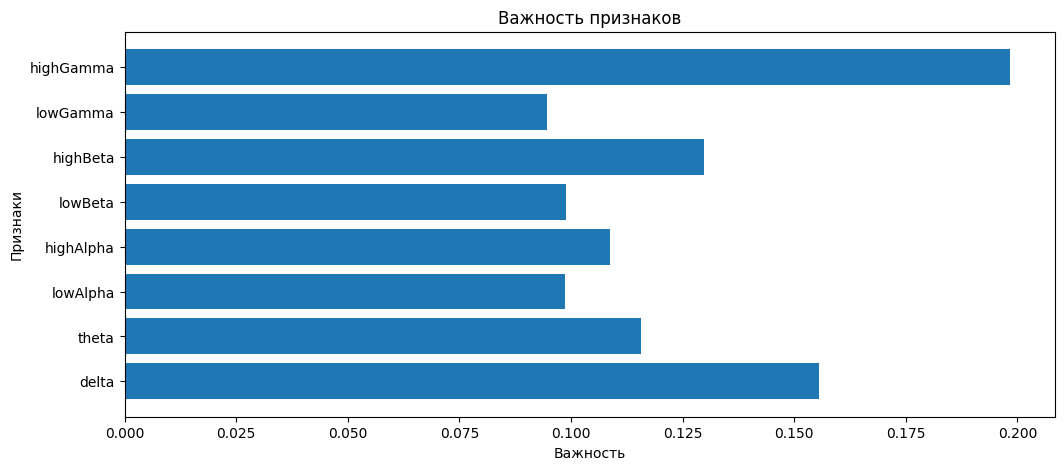

In [25]:


clf = RandomForestClassifier()
clf.fit(X, Y)

#Построение диаграммы
plt.figure(figsize=(12,5))
plt.barh(X.columns, clf.feature_importances_)
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

#create a figure to plot a bar, where x axis is features, and Y indicating the importance of each feature
#plt.figure(figsize=(12,12))
#plt.bar(X.columns, clf.feature_importances_)
#plt.show()

In [26]:
# метод с использованием SelectKBest

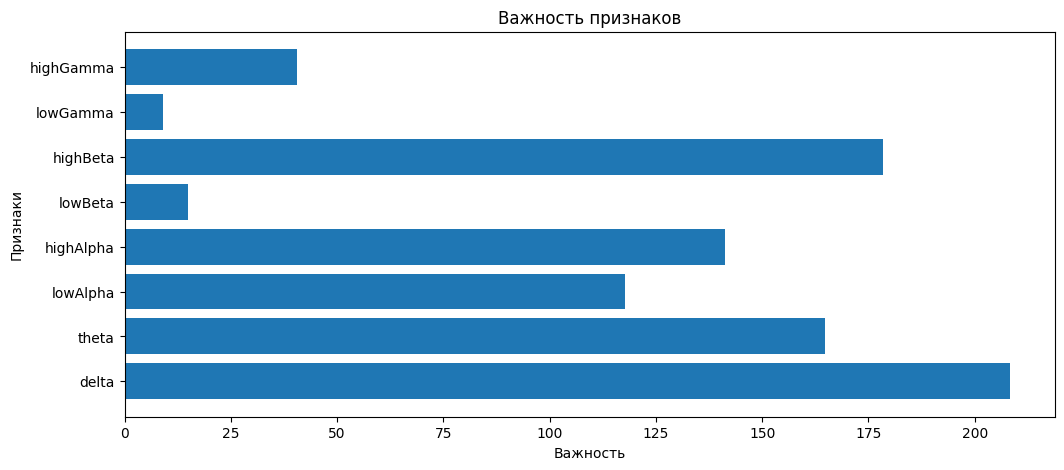

In [27]:
selector = SelectKBest(score_func=f_classif, k='all') # 'all' означает выбрать все признаки
selector.fit(X, Y)

scores = selector.scores_ #оценки важности признаков

# Создаём график важности признаков
plt.figure(figsize=(12,5))
plt.barh(X.columns, scores)
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

Можно сделать вывод, что в тройку самых важных признаков входят delta, highBeta и theta. Но от всех остальных признаков мы избавляться тоже не будем, поскольку у нас всего 8 признаков, что очень мало.

# Создание и обучение моделей, подбор гиперпараметров

In [29]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split

from sklearn import metrics

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
# Список моделей для классификации
models = [
    {
    'name': 'Logistic Regression',
    'model': LogisticRegression(),
    'params': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'] # убрала 'l1'
        }
    },
    {
    'name': 'SGD',
    'model': SGDClassifier(),
    'params': {
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'penalty': ['l1', 'l2'],
        'max_iter': [1000, 2000, 3000]
        }   
    },
    {
    'name': 'KNN',
    'model': KNeighborsClassifier(),
    'params': {'n_neighbors': [3, 5, 7]}
    },  
    {   
    'name': 'Decision Tree',
    'model': DecisionTreeClassifier(),
    'params': {'max_depth': [None, 1, 3, 5]} #             
    },
    {
    'name': 'Random Forest',
    'model': RandomForestClassifier(),
    'params': {
        'n_estimators': [10, 50, 100]#,
    #    'max_depth': [None, 5, 10]
        } 
    },  
    {
    'name': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
    'params': {'learning_rate': [0.1, 0.01, 0.001]}  
    }
]

best_model = None
best_score = 0
best_params = 0

for model_data in models:
    model = model_data['model']
    params = model_data['params']
    
    grid = GridSearchCV(model, params, cv=5)
    grid.fit(X_train, y_train)
    print(f"Лучшая оценка для {model_data['name']} : {grid.best_score_} \n")
#    print(grid.best_params_)
#    print(grid.best_score_)
#    print('')
    model_best_params = grid.best_params_ # убрать лишнюю переменную
    
    if grid.best_score_ > best_score:
        best_model = model_data['name']
        best_score = grid.best_score_
        best_params = model_best_params

# Вывод наилучшей модели и ее оценки (accuracy)
print(f"Итоговая лучшая модель: {best_model}")
print(f"Лучшие параметры модели: {best_params}")
print(f"Итоговая лучшая оценка: {best_score}")

Лучшая оценка для Logistic Regression : 0.6339025515922726 

Лучшая оценка для SGD : 0.6537914917620858 

Лучшая оценка для KNN : 0.7146106678974089 

Лучшая оценка для Decision Tree : 0.7146157959898316 

Лучшая оценка для Random Forest : 0.7582287568771383 

Лучшая оценка для Gradient Boosting : 0.7574632059368659 

Best Model: Random Forest
Best Parameters: {'n_estimators': 100}
Best Score: 0.7582287568771383


In [31]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Создание визуализации с помощью plotly
fig = ff.create_annotated_heatmap(
    z=confusion_matrix,
    x=['Predicted 0', 'Predicted 1'],
    y=['True 0', 'True 1'],
    colorscale='Viridis',
    showscale=True
)

# Настройка визуализации
fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)
fig.update_layout(height=500, width=700)  # указываем высоту и ширину графика
# Отображение визуализации
fig.show()

In [32]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       639
           1       0.76      0.69      0.72       482

    accuracy                           0.77      1121
   macro avg       0.77      0.76      0.76      1121
weighted avg       0.77      0.77      0.77      1121



In [33]:
import pickle

# Производим сериализацию и записываем результат в файл формата pkl
with open('model_rfc.pkl', 'wb') as output:
    pickle.dump(rfc, output)
    
with open('model_rfc.pkl', 'rb') as input:
    model_pkl = pickle.load(input)

In [34]:
from flask import Flask, request, jsonify
import pickle
import numpy as np

#with open('./models/model.pkl', 'rb') as pkl_file: 
#    model = pickle.load(pkl_file)

app = Flask(__name__)

n_features = 8

@app.route('/predict', methods=['POST'])
def predict():
    features = np.array(request.json)
    features = features.reshape(1, n_features) # если я правильно поняла, что мы подаём на вход по одной записи (а признаков в модели у нас 8), а не все записи сразу
    prediction = model_pkl.predict(features)
    return  jsonify({'prediction': prediction[0]})

if __name__ == '__main__':
    
    app.run('localhost', 5000)



 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:5000
Press CTRL+C to quit
